In [1]:
using PyPlot

In [2]:
# from https://github.com/JuliaLang/julia/blob/master/examples/ndgrid.jl
function meshgrid{T}(vx::AbstractVector{T}, vy::AbstractVector{T})
  m, n = length(vy), length(vx)
  vx = reshape(vx, 1, n)
  vy = reshape(vy, m, 1)
  (repmat(vx, m, 1), repmat(vy, 1, n))
end

meshgrid (generic function with 1 method)

In [3]:
type Intercept
    v
    ϵ
end

In [4]:
kerbinRadius = 600000.0
munRadius    = 200000.0
munSOI       = 2429559.6
munAltitude  = 12000000.0
muKerbin     = 3.5315984e12
muMun        = 6.5138398e10
vMun         = 542.5   #speed of mun's orbit
ωₘ           = vMun/(2*pi*munAltitude)*2pi

4.520833333333333e-5

In [5]:
#r0: departure altitude, v0: departure speed, ϕ₀: departure angle, λ: mun arrival angle
function lunarInterceptBate(r0,v0,ϕ₀,λ)
    #want to find velocity vector at lunar intercept
    E = v0^2/2 - muKerbin/r0
    h = r0*v0*cos(ϕ₀)
    r1 = 0
    v1 = 0
    ϕ₁ = 0
    γ₁ = 0
    try
        r1 = sqrt(munAltitude^2+munSOI^2-2*munAltitude*munSOI*cos(λ))
        v1 = sqrt(2*(E+muKerbin/r1))
        ϕ₁ = acos(h/(r1*v1))
        γ₁ = asin(munSOI/r1*sin(λ))
    catch error
        return Intercept(-1,0)
    end
    
    #fully specified parameters of the Munar orbit
    r2 = munSOI
    v2 = sqrt(v1^2+vMun^2-2*v1*vMun*cos(ϕ₁-γ₁))   #speed at intercept in Mun frame
    ϵ₂ = asin(vMun/v2*cos(λ)-v1/v2*cos(λ+γ₁-ϕ₁))  #negative sometimes
    
    return Intercept(v2,ϵ₂)
end

lunarInterceptBate (generic function with 1 method)

In [6]:
#returns the lunar periapsis of a given lunar intercept
function lunarPeriapsis(k)
    v2 = k.v
    if v2<0
        return munSOI
    end
    ϵ₂ = k.ϵ   
    r2 = munSOI
    E₂ = v2^2/2-muMun/r2
    h₂ = r2*v2*sin(ϵ₂)
    p = h₂^2/muMun
    ecc = sqrt(1+2*E₂*h₂^2/muMun^2)
    rₚ = p/(1+ecc)                 #wow! ecc here used to be just e=2.718...! big effect!!
    
    return rₚ
end

lunarPeriapsis (generic function with 1 method)

In [13]:
#TODO find a way to reuse code from lunarPeriapsis - most of this is copied
#key stuff derived from https://en.wikipedia.org/wiki/Hyperbola#Polar_coordinates
function lunarDeflectionAngle(intercept)
    v2 = intercept.v
    if v2<0
        return munSOI
    end
    ϵ₂ = intercept.ϵ
    r2 = munSOI
    E₂ = v2^2/2-muMun/r2
    h₂ = r2*v2*sin(ϵ₂)
    p = h₂^2/muMun
    ecc = sqrt(1+2*E₂*h₂^2/muMun^2)
    #println("Lunar orbit parameter: ", round(p, 3),",  ecc: ",round(ecc,3))
    interceptToPeriapsisAngle = 0
    try
        interceptToPeriapsisAngle = acos((1-p/munSOI)/ecc)
    catch e
        return 0
    end
    return 2*interceptToPeriapsisAngle     #Interior angle between the asymptotes as measured from the Mun's center
end

lunarDeflectionAngle (generic function with 1 method)

In [43]:
p1 = 1461230
ecc1 = 2.3647
2*acos((1-p1/munSOI)/ecc1)

2.8028829901978147

In [14]:
#only considers typical free return orbits - approaching from below
function lunarExitAngle(intercept, entryAngle)
    deflection = lunarDeflectionAngle(intercept)
    ϵ = intercept.ϵ
    if ϵ > 0
        return entryAngle+deflection
    else
        return entryAngle-deflection
    end
end
        

lunarExitAngle (generic function with 1 method)

In [9]:
#https://en.wikipedia.org/wiki/True_anomaly#Radius_from_true_anomaly
function trueAnomalyAtIntercept(a, ecc, r)
    return acos(((a/r*(1-ecc^2))-1)/ecc)
end

function smallAngle(r,λ)
    return asin(munSOI/r*sin(λ))
end

smallAngle (generic function with 1 method)

In [10]:
function timeOfFlight(r,a,ecc)
    E = acos((1-r/a)/ecc)
    tof = sqrt(a^3/muKerbin)*(E-ecc*sin(E))
    return tof
end

timeOfFlight (generic function with 1 method)

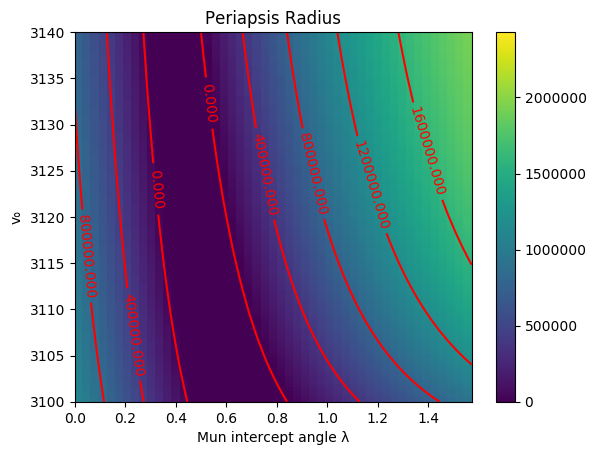

PyObject <matplotlib.text.Text object at 0x7f82eb5c9110>

In [11]:
vStart = 3100 #3080
vEnd = 3140   #3200
numV = 100
lambdaStart = 0
lambdaEnd = pi/2
numLambda = 50

#space across lambdas (mun intercept point angles) and v_0s
Λ,V = sampleSpace = meshgrid(linspace(lambdaStart,lambdaEnd,numLambda),
                             linspace(vStart,vEnd,numV))

#lunar periapsis radii at each λ, v point
#R = lunarDeflectionAngle.(lunarInterceptBate.(100000+kerbinRadius,V,0.00001,Λ))
R = lunarPeriapsis.(lunarInterceptBate.(100000+kerbinRadius,V,0,Λ))-munRadius

fig1 = figure()
  ax = fig1[:gca]()
p = pcolormesh(Λ, V, R, vmin=0, vmax=munSOI)
#p = pcolormesh(Λ, V, R, vmin = -pi, vmax =pi)
colorbar()
C = contour(Λ, V, R,6,colors="r")
clabel(C, inline=1, fontsize=10)
title("Periapsis Radius")
ylabel("v₀")
xlabel("Mun intercept angle λ")

In [23]:
v0 = 3135
r0 = 700000
λ = 0.55        #.43
t=140000

E = v0^2/2-muKerbin/r0
a = -muKerbin/(2*E)
munInt = lunarInterceptBate(r0,v0,0.0001,λ)
rₚ= lunarPeriapsis(munInt)
#println("Munar ϵ: ", munInt.ϵ)
print("Deflection angle: ", lunarDeflectionAngle(munInt))
println(" Exit angle: ", lunarExitAngle(munInt, λ))

print("Orbit params: e=", round(1-r0/a,4),", a=",round(a,1),"\n")
print("Munar periapsis: ", round(rₚ-munRadius), "m above surface\n")

ecc = 1-r0/a
interceptRadius = sqrt(munAltitude^2+munSOI^2-2*munAltitude*munSOI*cos(λ))

interceptTrueAnomaly = trueAnomalyAtIntercept(a, ecc, interceptRadius)
delta = smallAngle(interceptRadius, λ)
munPosition = 1.7
ToF = timeOfFlight(interceptRadius,a,ecc)

println("Intercept at ", round(interceptRadius), "m and true anomaly ", interceptTrueAnomaly, "r");
println("Argument of periapsis: ", round((munPosition+delta-interceptTrueAnomaly)*180/pi,4))
println("Time of flight: ", ToF, "s")
printSpeeds(r0,v0,0.0001,λ)

#print("run tothemun.ks(", round(a,1), ",",round(orbitAngle,4),",",1400000,").")

Deflection angle: 2.651102806555902 Exit angle: -2.101102806555902
Orbit params: e=0.9481, a=1.34764954e7
Munar periapsis: 71247.0m above surface
Intercept at 1.0009622e7m and true anomaly 2.71671994548261r
Argument of periapsis: -50.9651
Time of flight: 10096.308547567964s


LoadError: UndefVarError: printSpeeds not defined

Got a, e, and AoP all worked out. Just need periapsis epoch time. For an intercept at t=0 (like we have above), epoch time is -ToF. In HyperEdit just set Mean Anomaly at Epoch to 0 and Epoch to -ToF.

Need to figure out how to handle those orbits that reach the Mun on the downward part ($\nu > \pi$)

In [10]:
#r0: departure altitude, v0: departure speed, ϕ₀: departure angle, λ: mun arrival angle
function printSpeeds(r0,v0,ϕ₀,λ)
    #want to find velocity vector at lunar intercept
    E = v0^2/2 - muKerbin/r0
    h = r0*v0*cos(ϕ₀)
    r1 = 0
    v1 = 0
    ϕ₁ = 0
    γ₁ = 0
    
    r1 = sqrt(munAltitude^2+munSOI^2-2*munAltitude*munSOI*cos(λ))
    v1 = sqrt(2*(E+muKerbin/r1))
    ϕ₁ = acos(h/(r1*v1))
    γ₁ = asin(munSOI/r1*sin(λ))
    
    print("Total speed (Kerbin): ", round(v1,1), "\nRadial speed (Kerbin): ",round(v1*sin(ϕ₁),1),"\n")
    
    #fully specified parameters of the Munar orbit
    r2 = munSOI
    v2 = sqrt(v1^2+vMun^2-2*v1*vMun*cos(ϕ₁-γ₁))   #speed at intercept in Mun frame
    ϵ₂ = asin(vMun/v2*cos(λ)-v1/v2*cos(λ+γ₁-ϕ₁))
    print("Total speed (Mun): ", round(v2,1), "\nRadial speed (Mun): ",round(v2*cos(ϵ₂),1),"\n")
end

printSpeeds (generic function with 1 method)

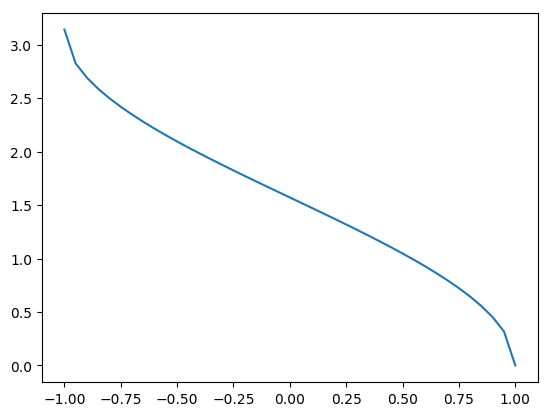

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb410896410>

In [28]:
Λ = linspace(0.3,0.8,41)
R = (x->lunarExitAngle(lunarInterceptBate(700000,3100,0.0001,x),x)*180/pi).(Λ)
p = plot(Λ, R)

To run get the ship to fly the right orbit:

`run tothemun.ks(7353189,5.8989,1400000).`


## Midcourse Corrections

I'll start with a fixed time-of-arrival correction. To proceed we need the time of arrival $t_A$, the point of arrival $\vec{r_A}$, and the position and velocity errors at the time of the correction. I will calculate the correction burn vector $\Delta\vec{v_C}$ and the error in direction and magnitude at the intercept point.

Need to determine $v(t_A)$ for the true orbit and the desired orbit. What parameters are needed? $a$, $e$, and argument of periapsis would do it. I need to determine the post-correction orbit from arrival time and position and burn time, position. Post-burn velocity is an unknown because I'm solving for it. This type of orbit determination is called Lambert's Problem.

$\psi$ has to do with Eccentric Anomalies - Battin p.278 - but those require a knowledge of the eccentricity

Battin p. 274 gives a possible value for eccentricity from position alone. Bate might give a more applied treatment of the problem

Battin p. 249 gives a very approachable-looking method of finding the eccentricity

Actually it's very easy to get the parameter from the eccentricity, but you do need $a$. 



The wikipedia page on Lambert's problem has a good walkthrough of orbit determination. 

Once the orbits are determined, I need to find the position and velocity at $t_C$

In [21]:
2.8794775901996372*180/pi

164.98191312094002

### 